In [1]:
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from xgboost import XGBClassifier, DMatrix, plot_importance, plot_tree
from lightgbm import LGBMClassifier, Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
catboost_params = {
    "iterations": 1000,
    "depth": 3,
    "learning_rate": 0.08,
    "loss_function": "Logloss",
    "verbose": False,
    "eval_metric": 'AUC',
    "od_type": 'Iter',
    "od_wait": 150,
}

lr_params = {
    "C": 1.5,
    "fit_intercept": True,
    "max_iter": 300,
    "penalty": "l1",
    "random_state": 123,
    "solver": "liblinear"
}

catboost_columns = [
    'term',
    'acc_open_past_24mths', # 677 02
    'funded_amnt',
    'percent_per_year',
    'additional_dti', #671
    'num_accts_ever_120_pd',
    'annual_inc', # 682 024,
    'tot_hi_cred_lim',
    'purpose', # 6839 035
    'home_ownership', # 683 027
]

catboost_cat_features = [
    'purpose',
    'home_ownership',
]

lr_cols = [
    'percent_per_year',
    'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    
    'installment',
    'is_first_loan',
    'avg_cur_bal',
    'is_emp_length_unknown',
    'even_salary',
]

lgbm_params = {
    'objective': 'binary',
    'max_depth': 1,
    'learning_rate': 0.05,
    'lambda_l2': 0.01,
    'seed': 17,
    'n_estimators': 1000,
    'min_child_weight': 40,
}

knn_params = {
    "n_neighbors": 130,
    "weights": 'distance',
}

knn_columns = [
    'percent_per_year',
    'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    
    'installment',
    'is_first_loan',
    'avg_cur_bal',
    'is_emp_length_unknown',
    'even_salary',
]

lgbm_columns = [
    'percent',
    'acc_open_past_24mths',
    'avg_cur_bal',
    'loan_income_ratio',
    'annual_inc',
    'tot_hi_cred_lim',
    'additional_dti',
    'percent_per_year',
    'purpose',
    'dti',
    'home_ownership',
    'num_accts_ever_120_pd',
    'psk',
    'is_emp_length_unknown',
    'funded_amnt',
]

lgbm_cat_features = [
    'purpose',
    'home_ownership',
]

xgb_columns = [   
    'dti',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'acc_open_past_24mths',
    'tot_hi_cred_lim',
    'purpose',
    'home_ownership',
    'psk',
    'percent',
    'loan_income_ratio',
    'is_emp_length_unknown',
    'funded_amnt_mod_100',   
]


xgb_params = {
    'max_depth': 1,
    'learning_rate': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 10,
    'n_estimators': 1500,
}

In [3]:
def init_and_fit_model(x_train, x_test, y_train, y_test, params, cat_features, model):
    if model=='catboost':
        eval_dataset = Pool(x_test, y_test, cat_features)
        inner_model = CatBoostClassifier(**params)

        inner_model.fit(
            x_train,  
            y_train,
            cat_features,
            eval_set=eval_dataset,
            verbose=50,
            use_best_model=True,
        )
    elif model == 'logreg':
        inner_model = LogisticRegression(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'lgbm':
        inner_model = LGBMClassifier(**params)
        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=50,
            categorical_feature=cat_features,
        )
    elif model == 'knn':
        inner_model = KNeighborsClassifier(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'xgboost':
        inner_model = XGBClassifier(**xgb_params, )

        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=150,
        )
    return inner_model

def do_cv(x_train, x_test, y_train, features, cat_features, params, splitter, model='catboost'):
    oof_result = pd.Series([0] * x_train.shape[0], index=x_train.index)
    result = [0] * x_test.shape[0]
    scores = []
    for ind_trn, ind_test in splitter.split(x_train, y_train):
        X_train_df = x_train[features].iloc[ind_trn]
        X_valid_df = x_train[features].iloc[ind_test]
        y_train_df = y_train.iloc[ind_trn]
        y_valid_df = y_train.iloc[ind_test]

        fitted_model = init_and_fit_model(
            X_train_df,
            X_valid_df,
            y_train_df,
            y_valid_df,
            params,
            cat_features,
            model
        )
        
        scores.append(roc_auc_score(y_valid_df, fitted_model.predict_proba(X_valid_df)[:, 1]))
        result += fitted_model.predict_proba(x_test[features])[:, 1:].flatten()/5
        oof_result.loc[X_valid_df.index] = fitted_model.predict_proba(X_valid_df)[:, 1]
        
    return scores, result, oof_result

In [4]:
catboost_train = pd.read_csv('data/catboost_train.csv')
catboost_test = pd.read_csv('data/catboost_test.csv')
lgbm_train = pd.read_csv('data/catboost_train.csv')
lgbm_test = pd.read_csv('data/catboost_test.csv')
logreg_train = pd.read_csv('data/logreg_train.csv')
logreg_test = pd.read_csv('data/logreg_test.csv')

In [5]:
cat_cols = [
    'purpose',
    'home_ownership',
    'subgrade'
]

for cat_cols in cat_cols:
    le = LabelEncoder()
    lgbm_train[cat_cols] = le.fit_transform(lgbm_train[cat_cols])
    lgbm_test[cat_cols] = le.transform(lgbm_test[cat_cols])

In [6]:
catboost_train_small, catboost_valid, catboost_y_train, catboost_y_valid = train_test_split(
    catboost_train.drop(columns=['def'], axis=1),
    catboost_train['def'],
    test_size=0.2,
    random_state=18,
    stratify=catboost_train['def']
)

logreg_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
logreg_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
logreg_y_train = logreg_train.loc[catboost_train_small.index]['def']
logreg_y_valid = logreg_train.loc[catboost_valid.index]['def']

lgbm_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
lgbm_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
lgbm_y_train = lgbm_train.loc[catboost_train_small.index]['def']
lgbm_y_valid = lgbm_train.loc[catboost_valid.index]['def']

xgb_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
xgb_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
xgb_y_train = lgbm_train.loc[catboost_train_small.index]['def']
xgb_y_valid = lgbm_train.loc[catboost_valid.index]['def']

knn_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
knn_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
knn_y_train = logreg_train.loc[catboost_train_small.index]['def']
knn_y_valid = logreg_train.loc[catboost_valid.index]['def']

In [7]:
skf = StratifiedKFold(n_splits=5, random_state=18, shuffle=True)
cb_scores, cb_result, cb_oof_result = do_cv(
    catboost_train_small,
    catboost_valid,
    catboost_y_train,
    catboost_columns,
    catboost_cat_features,
    catboost_params,
    skf,
    'catboost'
)

lr_scores, lr_result, lr_oof_result = do_cv(
    logreg_train_small,
    logreg_valid,
    logreg_y_train,
    lr_cols,
    [],
    lr_params,
    skf,
    'logreg',
)

skf = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)
lgbm_scores, lgbm_result, lgbm_oof_result = do_cv(
    lgbm_train_small,
    lgbm_valid,
    lgbm_y_train,
    lgbm_columns,
    lgbm_cat_features,
    lgbm_params,
    skf,
    'lgbm'
)

knn_scores, knn_result, knn_oof_result = do_cv(
    knn_train_small,
    knn_valid,
    knn_y_train,
    knn_columns,
    [],
    knn_params,
    skf,
    'knn'
)

xgb_scores, xgb_result, xgb_oof_result = do_cv(
    xgb_train_small,
    xgb_valid,
    xgb_y_train,
    xgb_columns,
    [],
    xgb_params,
    skf,
    'xgboost'
)

0:	test: 0.6377540	best: 0.6377540 (0)	total: 5.42s	remaining: 1h 30m 18s
50:	test: 0.6841575	best: 0.6841575 (50)	total: 7.1s	remaining: 2m 12s
100:	test: 0.6856700	best: 0.6859183 (97)	total: 9.1s	remaining: 1m 20s
150:	test: 0.6854248	best: 0.6859183 (97)	total: 11.5s	remaining: 1m 4s
200:	test: 0.6849595	best: 0.6859183 (97)	total: 13.6s	remaining: 54s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6859182934
bestIteration = 97

Shrink model to first 98 iterations.
0:	test: 0.6201116	best: 0.6201116 (0)	total: 28.3ms	remaining: 28.3s
50:	test: 0.6738377	best: 0.6738811 (48)	total: 2.42s	remaining: 45.1s
100:	test: 0.6739774	best: 0.6741445 (76)	total: 4.25s	remaining: 37.8s
150:	test: 0.6741315	best: 0.6742907 (147)	total: 6.25s	remaining: 35.1s
200:	test: 0.6737038	best: 0.6744087 (179)	total: 8.52s	remaining: 33.9s
250:	test: 0.6730407	best: 0.6744087 (179)	total: 10.5s	remaining: 31.2s
300:	test: 0.6728879	best: 0.6744087 (179)	total: 12.4s	remaining: 28.8s

d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.688404	valid_0's binary_logloss: 0.413602
[200]	valid_0's auc: 0.691765	valid_0's binary_logloss: 0.411208
[300]	valid_0's auc: 0.693245	valid_0's binary_logloss: 0.410451
[400]	valid_0's auc: 0.69427	valid_0's binary_logloss: 0.410068
Early stopping, best iteration is:
[390]	valid_0's auc: 0.69437	valid_0's binary_logloss: 0.41004


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.697626	valid_0's binary_logloss: 0.411719
[200]	valid_0's auc: 0.702557	valid_0's binary_logloss: 0.40832
[300]	valid_0's auc: 0.703573	valid_0's binary_logloss: 0.407186
[400]	valid_0's auc: 0.704416	valid_0's binary_logloss: 0.40653
[500]	valid_0's auc: 0.704719	valid_0's binary_logloss: 0.406245
Early stopping, best iteration is:
[464]	valid_0's auc: 0.704745	valid_0's binary_logloss: 0.406303


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.677319	valid_0's binary_logloss: 0.415939
[200]	valid_0's auc: 0.681535	valid_0's binary_logloss: 0.413448
[300]	valid_0's auc: 0.684394	valid_0's binary_logloss: 0.412425
[400]	valid_0's auc: 0.685134	valid_0's binary_logloss: 0.412154
[500]	valid_0's auc: 0.68564	valid_0's binary_logloss: 0.412011
Early stopping, best iteration is:
[531]	valid_0's auc: 0.685763	valid_0's binary_logloss: 0.411991


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.667136	valid_0's binary_logloss: 0.417184
[200]	valid_0's auc: 0.672391	valid_0's binary_logloss: 0.41463
[300]	valid_0's auc: 0.675438	valid_0's binary_logloss: 0.413633
[400]	valid_0's auc: 0.677164	valid_0's binary_logloss: 0.413103
[500]	valid_0's auc: 0.678098	valid_0's binary_logloss: 0.412779
[600]	valid_0's auc: 0.678805	valid_0's binary_logloss: 0.41259
[700]	valid_0's auc: 0.679152	valid_0's binary_logloss: 0.412478
[800]	valid_0's auc: 0.679329	valid_0's binary_logloss: 0.412443
[900]	valid_0's auc: 0.679414	valid_0's binary_logloss: 0.412402
Early stopping, best iteration is:
[872]	valid_0's auc: 0.679465	valid_0's binary_logloss: 0.412389


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.658521	valid_0's binary_logloss: 0.41919
[200]	valid_0's auc: 0.663803	valid_0's binary_logloss: 0.417045
[300]	valid_0's auc: 0.666114	valid_0's binary_logloss: 0.416394
[400]	valid_0's auc: 0.667387	valid_0's binary_logloss: 0.416191
[500]	valid_0's auc: 0.667998	valid_0's binary_logloss: 0.416166
Early stopping, best iteration is:
[460]	valid_0's auc: 0.667912	valid_0's binary_logloss: 0.416133
[0]	validation_0-auc:0.62668
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.69255
[200]	validation_0-auc:0.69516
[300]	validation_0-auc:0.69605
[400]	validation_0-auc:0.69668
[500]	validation_0-auc:0.69673
[600]	validation_0-auc:0.69659
Stopping. Best iteration:
[510]	validation_0-auc:0.69681

[0]	validation_0-auc:0.63619
Will train until validation_0-auc hasn't i

In [8]:
new_train_df = pd.DataFrame({
    'lr':lr_oof_result,
    'cb':cb_oof_result,
    'lgbm': lgbm_oof_result,
#     'knn': knn_oof_result,
    'xgb': xgb_oof_result,
})
new_test_df = pd.DataFrame({
    'lr':lr_result,
    'cb':cb_result,
    'lgbm': lgbm_result,
#     'knn': knn_result,
    'xgb': xgb_result,
})

In [9]:
roc_auc_score(catboost_y_valid, new_test_df.mean(axis=1))

0.6853892636914629

In [10]:
roc_auc_score(catboost_y_valid, new_test_df.mean(axis=1))

0.6853892636914629

In [11]:
roc_auc_score(catboost_y_train, new_train_df.mean(axis=1))

0.6891640245907762

In [12]:
roc_auc_score(catboost_y_train, new_train_df.mean(axis=1))

0.6891640245907762

In [13]:
metamodel = LogisticRegression(C=1, solver='liblinear')
metamodel.fit(new_train_df, logreg_y_train)

LogisticRegression(C=1, solver='liblinear')

In [14]:
roc_auc_score(logreg_y_valid, metamodel.predict_proba(new_test_df)[:, 1])

0.6856858832175968

In [15]:
roc_auc_score(logreg_y_valid, metamodel.predict_proba(new_test_df)[:, 1])

0.6856858832175968

In [16]:
roc_auc_score(logreg_y_valid, metamodel.predict_proba(new_test_df)[:, 1])

0.6856858832175968

In [17]:
roc_auc_score(logreg_y_train, metamodel.predict_proba(new_train_df)[:, 1])

0.6894162514061001

In [18]:
roc_auc_score(logreg_y_train, metamodel.predict_proba(new_train_df)[:, 1])

0.6894162514061001

In [19]:
metamodel.coef_

array([[0.80178449, 1.9115568 , 1.30146043, 2.84612896]])

In [20]:
new_train_df

,lr,cb,lgbm,xgb
14109,0.133083,0.138812,0.124940,0.114643
18950,0.126551,0.114928,0.126182,0.126996
3675,0.371916,0.282020,0.340191,0.234288
16429,0.272874,0.275728,0.255059,0.240526
13475,0.363980,0.329877,0.277229,0.244470
...,...,...,...,...
28334,0.066210,0.047371,0.050185,0.052842
5861,0.060163,0.071585,0.088737,0.074193
26451,0.173425,0.156740,0.154682,0.231377
2572,0.164120,0.164634,0.172908,0.170319


In [21]:
for col in new_train_df:
    print(col, roc_auc_score(logreg_y_train, new_train_df[col]),  roc_auc_score(logreg_y_valid, new_test_df[col]))

lr 0.6857654998911564 0.6818362149371002
cb 0.685423932021476 0.6832470115582743
lgbm 0.6860472346701304 0.6839088438759603
xgb 0.6885567370580233 0.685031466388064


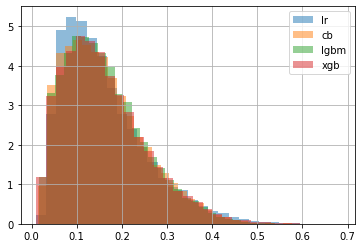

In [23]:
new_train_df['lr'].hist(alpha=0.5, bins=30, density='uniform', label='lr')
new_train_df['cb'].hist(alpha=0.5, bins=30, density='uniform', label='cb')
new_train_df['lgbm'].hist(alpha=0.5, bins=30, density='uniform', label='lgbm')
# new_train_df['knn'].hist(alpha=0.5, bins=30, density='uniform', label='knn')
new_train_df['xgb'].hist(alpha=0.5, bins=30, density='uniform', label='xgb')
plt.legend()
plt.show()


In [24]:
skf = StratifiedKFold(n_splits=5, random_state=18, shuffle=True)
cb_scores, cb_result, cb_oof_result = do_cv(
    catboost_train,
    catboost_test,
    catboost_train['def'],
    catboost_columns,
    catboost_cat_features,
    catboost_params,
    skf,
    'catboost'
)

lr_scores, lr_result, lr_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    lr_cols,
    [],
    lr_params,
    skf,
    'logreg',
)

skf = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)
lgbm_scores, lgbm_result, lgbm_oof_result = do_cv(
    lgbm_train,
    lgbm_test,
    lgbm_train['def'],
    lgbm_columns,
    lgbm_cat_features,
    lgbm_params,
    skf,
    'lgbm'
)

knn_scores, knn_result, knn_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    knn_columns,
    [],
    knn_params,
    skf,
    'knn'
)

xgb_scores, xgb_result, xgb_oof_result = do_cv(
    lgbm_train,
    lgbm_test,
    lgbm_train['def'],
    xgb_columns,
    [],
    xgb_params,
    skf,
    'xgboost'
)

0:	test: 0.5957648	best: 0.5957648 (0)	total: 28.8ms	remaining: 28.8s
50:	test: 0.6797898	best: 0.6798746 (48)	total: 1.61s	remaining: 30s
100:	test: 0.6810752	best: 0.6812684 (97)	total: 2.93s	remaining: 26.1s
150:	test: 0.6820397	best: 0.6821300 (139)	total: 4.21s	remaining: 23.7s
200:	test: 0.6822375	best: 0.6823633 (191)	total: 5.6s	remaining: 22.3s
250:	test: 0.6825189	best: 0.6827930 (233)	total: 7.32s	remaining: 21.8s
300:	test: 0.6827897	best: 0.6828472 (295)	total: 8.63s	remaining: 20.1s
350:	test: 0.6827372	best: 0.6830738 (314)	total: 9.96s	remaining: 18.4s
400:	test: 0.6821118	best: 0.6830738 (314)	total: 11.7s	remaining: 17.5s
450:	test: 0.6816920	best: 0.6830738 (314)	total: 13.9s	remaining: 16.9s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.6830737775
bestIteration = 314

Shrink model to first 315 iterations.
0:	test: 0.6078289	best: 0.6078289 (0)	total: 32.9ms	remaining: 32.8s
50:	test: 0.6786438	best: 0.6786902 (49)	total: 2.34s	remaining: 43.5s

d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.679046	valid_0's binary_logloss: 0.414826
[200]	valid_0's auc: 0.685137	valid_0's binary_logloss: 0.411815
[300]	valid_0's auc: 0.687682	valid_0's binary_logloss: 0.410779
[400]	valid_0's auc: 0.688772	valid_0's binary_logloss: 0.410315
[500]	valid_0's auc: 0.689324	valid_0's binary_logloss: 0.410116
[600]	valid_0's auc: 0.689504	valid_0's binary_logloss: 0.410033
Early stopping, best iteration is:
[609]	valid_0's auc: 0.689591	valid_0's binary_logloss: 0.410005


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.669306	valid_0's binary_logloss: 0.417016
[200]	valid_0's auc: 0.674696	valid_0's binary_logloss: 0.414368
[300]	valid_0's auc: 0.677481	valid_0's binary_logloss: 0.413318
[400]	valid_0's auc: 0.679048	valid_0's binary_logloss: 0.412805
[500]	valid_0's auc: 0.679525	valid_0's binary_logloss: 0.412636
[600]	valid_0's auc: 0.68001	valid_0's binary_logloss: 0.412544
[700]	valid_0's auc: 0.680248	valid_0's binary_logloss: 0.41251
Early stopping, best iteration is:
[730]	valid_0's auc: 0.680304	valid_0's binary_logloss: 0.412499


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.685132	valid_0's binary_logloss: 0.413818
[200]	valid_0's auc: 0.6905	valid_0's binary_logloss: 0.41052
[300]	valid_0's auc: 0.692507	valid_0's binary_logloss: 0.409232
[400]	valid_0's auc: 0.693482	valid_0's binary_logloss: 0.408596
[500]	valid_0's auc: 0.693762	valid_0's binary_logloss: 0.408294
[600]	valid_0's auc: 0.693882	valid_0's binary_logloss: 0.40818
Early stopping, best iteration is:
[637]	valid_0's auc: 0.693936	valid_0's binary_logloss: 0.408138


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.672897	valid_0's binary_logloss: 0.416669
[200]	valid_0's auc: 0.676405	valid_0's binary_logloss: 0.414635
[300]	valid_0's auc: 0.677927	valid_0's binary_logloss: 0.414109
[400]	valid_0's auc: 0.678992	valid_0's binary_logloss: 0.413868
Early stopping, best iteration is:
[430]	valid_0's auc: 0.67919	valid_0's binary_logloss: 0.413826


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.685103	valid_0's binary_logloss: 0.414352
[200]	valid_0's auc: 0.689529	valid_0's binary_logloss: 0.411554
[300]	valid_0's auc: 0.692146	valid_0's binary_logloss: 0.410412
[400]	valid_0's auc: 0.693724	valid_0's binary_logloss: 0.409799
[500]	valid_0's auc: 0.693945	valid_0's binary_logloss: 0.409642
[600]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.409573
Early stopping, best iteration is:
[600]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.409573
[0]	validation_0-auc:0.61749
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.68140
[200]	validation_0-auc:0.68586
[300]	validation_0-auc:0.68772
[400]	validation_0-auc:0.68861
[500]	validation_0-auc:0.68900
[600]	validation_0-auc:0.68933
[700]	validation_0-auc:0.68937
Stopping. Best iteration:
[646]	

In [27]:
new_train_df = pd.DataFrame({
    'lr':lr_oof_result,
    'cb':cb_oof_result,
    'lgbm': lgbm_oof_result,
#     'knn': knn_oof_result,
    'xgb': xgb_oof_result,
})
new_test_df = pd.DataFrame({
    'lr':lr_result,
    'cb':cb_result,
    'lgbm': lgbm_result,
#     'knn': knn_result,
    'xgb': xgb_result,
})

In [28]:
roc_auc_score(logreg_train['def'], new_train_df.mean(axis=1))

0.6889367034791916

In [150]:
roc_auc_score(logreg_train['def'], new_train_df.mean(axis=1))

0.6878757217915781

In [29]:
for col in new_train_df:
    print(col, roc_auc_score(logreg_train['def'], new_train_df[col]))

lr 0.6852537514810764
cb 0.6852127164007448
lgbm 0.6873081371131118
xgb 0.6882096363151927


In [30]:
lr = LogisticRegression(C=1, solver='liblinear')
scores = cross_val_score(lr, new_train_df, logreg_train['def'], cv=5, scoring='roc_auc')

In [159]:
np.mean(scores), np.std(scores)

(0.6887594771265508, 0.007202475393397213)

In [31]:
np.mean(scores), np.std(scores)

(0.6889040548626651, 0.007235345573391267)

In [32]:
lr_f_scores, lr_f_result, lr_f_oof_result = do_cv(
    new_train_df,
    new_test_df,
    logreg_train['def'],
    new_train_df.columns,
    [],
    {},
    skf,
    'logreg',
)

In [33]:
logreg_test['prob'] = lr_f_result

In [34]:
logreg_test[['id', 'prob']].to_csv('blend_submission.csv', index=False)